## ML prediccion de emisiones de co2

In [2]:
#Librerias a usar

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Cargamos la data 

data1a='electric_cars_limpio.csv'
data2a='fuel_vehicles_limpio.csv'
dataa3='hybrid_vehicle_limpio.csv'

In [4]:
#Creamos dfs 
electric_emissions=pd.read_csv(data1a)
fuel_emissions=pd.read_csv(data2a)
hybrid_emissions=pd.read_csv(dataa3)

In [5]:
#Estandarizamos las columnas que vamos a usar esto nos va ayudar a concatenar 
electric_emissions = electric_emissions.rename(columns={'vehicle_code':'vehicle code','model':'make','fuel_type': 'fuel_type','emisiones_CO2_g_per_km': 'emissions_co2_g_per_km','power_kw': 'engine_power_kw',
    'electric_range_km': 'electric_range_km','year':'registration year'})
hybrid_emissions = hybrid_emissions.rename(columns={'fuel type': 'fuel_type','emissions co2 g/km (wltp)': 'emissions_co2_g_per_km',
    'engine power (kw)': 'engine_power_kw',
    'electric range (km)': 'electric_range_km',
    })
fuel_emissions = fuel_emissions.rename(columns={'fuel type': 'fuel_type','emissions co2 g/km (wltp)': 'emissions_co2_g_per_km',
    'engine power (kw)': 'engine_power_kw',
    })

In [6]:
#Seleccionamos las columnas que vamos a utilizar 
electriccolumns=['identifier','manufacturer','make','fuel_type', 'emissions_co2_g_per_km', 
                   'energy_consumption_wh_per_km', 'engine_power_kw', 'electric_range_km', 'registration year']
fuelcolumns=['identifier','manufacturer', 'make', 'fuel_type', 'emissions_co2_g_per_km', 
                    'engine_power_kw', 'registration year','fuel consumption']

hybridcolumns=['identifier','manufacturer', 'make', 'fuel_type', 'emissions_co2_g_per_km','energy_consumption_wh_per_km', 
                    'engine_power_kw', 'electric_range_km','registration year','fuel consumption']

In [7]:
#Creamos data sets limpios 
electric_emissions_clean = electric_emissions[electriccolumns]
fuel_emissions_clean = fuel_emissions[fuelcolumns]
hybrid_emissions_clean = hybrid_emissions[hybridcolumns]

In [8]:
#Concatenamos 
combined_emissions = pd.concat([hybrid_emissions_clean, fuel_emissions_clean, electric_emissions_clean])

In [9]:
#Remplzamos nulos por 0 y quitamos duplicados 
combined_emissions=combined_emissions.fillna(0)
combined_emissions = combined_emissions.drop_duplicates()

In [10]:
#Exportamos el data set limpio a csv para poder usarlo en big query o en cualquier otra plataforma si es necesario 
combined_emissions.to_csv('combined_emissions_clean.csv', index=False)

In [11]:
#Lo volvemos a cargar para el modelo este paso lo podemos evitar si seguimos usando solo un script si ese fuera el caso seguimos trabajando con combined_emissions 

df = pd.read_csv('combined_emissions_clean.csv')

In [12]:
#Como tenemos una variable categorica usamos dummies para poder usarla con valores numéricos y que el modelo los pueda usar 
df = pd.get_dummies(df, columns=['fuel_type'], drop_first=True)

In [13]:
#Dividimos nuestras variables en dependientees e independientes 
X = df[['engine_power_kw', 'energy_consumption_wh_per_km', 'electric_range_km', 'registration year'] + [col for col in df if col.startswith('fuel_type_')]]
y = df['emissions_co2_g_per_km']

In [14]:
#Dividimos nuestros registros para el entrenamiento y el testeo y anclamos la seed para que no haya variaciones al correrlo en diferentes momentos 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [15]:
#Realizamos el modelo 
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

In [16]:
#Vemos las métricas de MSE y R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, R²: {r2}')

MSE: 575.8864604686372, R²: 0.8399509995840029


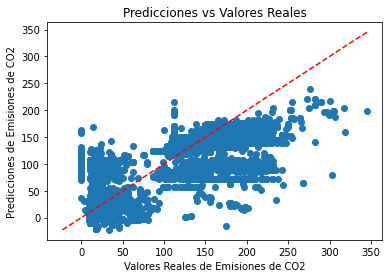

In [17]:
#Graficamos la distribucion de las predicciones vs los valores reales 
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales de Emisiones de CO2')
plt.ylabel('Predicciones de Emisiones de CO2')
plt.title('Predicciones vs Valores Reales')
min_value = min(min(y_test), min(y_pred))
max_value = max(max(y_test), max(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')
plt.show()

In [52]:
#Creamos un diccionario para hacer un df y poder predecir con valores nuevos 
nuevo_vehiculo = {
    'engine_power_kw': 91,
    'energy_consumption_wh_per_km': 0,
    'electric_range_km': 0,
    'registration year': 2023,
    'fuel_type_diesel/electric': 0,
    'fuel_type_e85': 1,
    'fuel_type_electric': 0,
    'fuel_type_petrol':0,
    'fuel_type_petrol/electric':0}
prediccion = pd.DataFrame([nuevo_vehiculo])

In [53]:
prediccion.head()

,engine_power_kw,energy_consumption_wh_per_km,electric_range_km,registration year,fuel_type_diesel/electric,fuel_type_e85,fuel_type_electric,fuel_type_petrol,fuel_type_petrol/electric
0,91,0,0,2023,0,1,0,0,0


In [54]:
#Realizamos nuevas predicciones en este caso en específico usamos valores del conjunto del testeo para oder observa como varia con el valor real 
prediccion_emisiones = model_lr.predict(prediccion)
print(f'Predicción de emisiones de CO2: {prediccion_emisiones[0]} g/km')

Predicción de emisiones de CO2: 124.6613896928491 g/km


In [55]:
#Creamos un df que nos de esta info del conjunto de testeo 
test_data=X_test.copy()
test_data['emissions_co2_g_per_km'] = y_test

In [56]:
#Observamos los valores  y vemos que hay una vaeriacion de +3.6 g/km en las emisiones de co2 un valor muy aceptable de predicción por lo que concluimos que el modelo es adecuado y funciona bien 
test_data.head()

,engine_power_kw,energy_consumption_wh_per_km,electric_range_km,registration year,fuel_type_diesel/electric,fuel_type_e85,fuel_type_electric,fuel_type_petrol,fuel_type_petrol/electric,emissions_co2_g_per_km
141880,91.0,0.0,0.0,2023,False,True,False,False,False,121.000000
102314,96.0,0.0,0.0,2023,False,False,False,True,False,149.000000
112176,116.0,0.0,0.0,2023,False,False,False,True,False,122.000000
1473,136.0,214.0,70.0,2023,False,False,False,False,True,25.000000
182364,150.0,169.0,520.0,2023,False,False,True,False,False,10.891111


In [57]:
#Prueba
data = {
    'engine_power_kw': [150, 180, 200],
    'energy_consumption_wh_per_km': [120, 100, 130],
    'electric_range_km': [100, 200, 300],
    'registration year': [2020, 2021, 2022],
    'fuel_type_diesel/electric': [0, 0, 1],
    'fuel_type_e85': [1, 0, 0],
    'fuel_type_electric': [0, 1, 0],
    'fuel_type_petrol': [1, 0, 0],
    'fuel_type_petrol/electric': [0, 0, 0]
}

df_vehiculos = pd.DataFrame(data)

In [59]:
#Funcion para poder ingresar un df y que te retonre el df con las predicciones
def predicciones_co2(df):
    predicciones = model_lr.predict(df)
    df['prediccion_emisiones_co2'] = predicciones
    return df


In [60]:
predicciones_co2(df_vehiculos)

,engine_power_kw,energy_consumption_wh_per_km,electric_range_km,registration year,fuel_type_diesel/electric,fuel_type_e85,fuel_type_electric,fuel_type_petrol,fuel_type_petrol/electric,prediccion_emisiones_co2
0,150,120,100,2020,0,1,0,1,0,82.631182
1,180,100,200,2021,0,0,1,0,0,62.582307
2,200,130,300,2022,1,0,0,0,0,44.824980


In [73]:
#Funcion para que el usuario ingrese por teclado info de un carro y te regrese la prediccion 
def pco2():
    engine_power_kw = float(input("Ingrese la potencia del motor (kW): "))
    energy_consumption_wh_per_km = float(input("Ingrese el consumo de energía (Wh por km): "))
    electric_range_km = float(input("Ingrese el rango eléctrico (km): "))
    registration_year = int(input("Ingrese el año de registro: "))
    fuel_type=int(input("¿Qué tipo de combustible usa?  1) Diesel/eléctrico  2) E85  3) Eléctrico  4) Gasolina  5) Gasolina/eléctrico Ingrese el número correspondiente: "))
    fuel_type_diesel_electric = (lambda x: 1 if x == 1 else 0)(fuel_type)
    fuel_type_e85 = (lambda x: 1 if x == 2 else 0)(fuel_type)
    fuel_type_electric = (lambda x: 1 if x == 3 else 0)(fuel_type)
    fuel_type_petrol = (lambda x: 1 if x == 4 else 0)(fuel_type)
    fuel_type_petrol_electric = (lambda x: 1 if x == 5 else 0)(fuel_type)
    data = {
        'engine_power_kw': [engine_power_kw],
        'energy_consumption_wh_per_km': [energy_consumption_wh_per_km],
        'electric_range_km': [electric_range_km],
        'registration year': [registration_year],
        'fuel_type_diesel/electric': [fuel_type_diesel_electric],
        'fuel_type_e85': [fuel_type_e85],
        'fuel_type_electric': [fuel_type_electric],
        'fuel_type_petrol': [fuel_type_petrol],
        'fuel_type_petrol/electric': [fuel_type_petrol_electric]
    }
    
    df = pd.DataFrame(data)
    prediccion = model_lr.predict(df)
    df['prediccion_emisiones_co2'] = prediccion
    return df

In [74]:
pco2()

,engine_power_kw,energy_consumption_wh_per_km,electric_range_km,registration year,fuel_type_diesel/electric,fuel_type_e85,fuel_type_electric,fuel_type_petrol,fuel_type_petrol/electric,prediccion_emisiones_co2
0,150.0,0.0,0.0,2024,0,0,0,1,0,143.068155
